<center> <h1>AI Agents : Powering LLMs With Web Search</h1>

### 1. Web Search Tool

#### 1.1 Tavily Search

In [1]:
%pip install langchain-tavily

   ---------------------------------------- 0.0/443.6 kB ? eta -:--:--
   ------------- -------------------------- 153.6/443.6 kB 4.6 MB/s eta 0:00:01
   --------------------------------- ------ 368.6/443.6 kB 5.7 MB/s eta 0:00:01
   ---------------------------------------- 443.6/443.6 kB 3.9 MB/s eta 0:00:00
   ---------------------------------------- 0.0/1.0 MB ? eta -:--:--
   ----------- ---------------------------- 0.3/1.0 MB 8.9 MB/s eta 0:00:01
   ----------------------- ---------------- 0.6/1.0 MB 7.5 MB/s eta 0:00:01
   ---------------------------------- ----- 0.9/1.0 MB 6.8 MB/s eta 0:00:01
   ---------------------------------------  1.0/1.0 MB 7.1 MB/s eta 0:00:01
   ---------------------------------------- 1.0/1.0 MB 5.4 MB/s eta 0:00:00
   ---------------------------------------- 0.0/417.1 kB ? eta -:--:--
   --------------------- ------------------ 225.3/417.1 kB 4.6 MB/s eta 0:00:01
   ---------------------------------------- 417.1/417.1 kB 4.3 MB/s eta 0:00:00
   ------


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: C:\Users\Admin\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [3]:
import yaml

with open('../secrets.yml', 'r') as file:
    credentials = yaml.safe_load(file)

In [6]:
from langchain_tavily import TavilySearch

search_tool = TavilySearch(
    max_results=5,
    topic="general",
    tavily_api_key=credentials["tavily"]["api_key"],
)

#### 1.2 Usage

In [7]:
search_tool.invoke("How is the Tesla stock doing?")

{'query': 'How is the Tesla stock doing?',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'title': 'Tesla falls after Commerce secretary recommends buying stock',
   'url': 'https://www.axios.com/2025/03/20/tesla-musk-lutnick',
   'content': "Elon Musk's Tesla falls after Commerce secretary urges Americans to buy stock Axios Axios Axios Tesla shares fell early Thursday after Commerce Secretary Howard Lutnick used a TV appearance to urge Americans to buy stock in Elon Musk's car company. President Trump and Elon Musk look at Tesla models on the South Lawn on Tuesday. President Trump and Elon Musk look at Tesla vehicles on the South Lawn of the White House on Tuesday. Tesla plunges, X suffers outages, on Elon Musk's bad day Investors are questioning whether Tesla's recently weakened stock and slipping sales are due to CEO Elon Musk's political involvement and online presence. About Axios",
   'score': 0.71496695,
   'raw_content': None},
  {'title': 'Tesla, I

### 2. Web-Powered Agent

#### 2.1 Langgraph Agent

In [8]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages

In [13]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

In [10]:
from langchain_aws import ChatBedrock

llm = ChatBedrock(
    model_id="us.anthropic.claude-3-5-sonnet-20240620-v1:0",
    region_name="us-east-1",
    aws_access_key_id=credentials["bedrock"]["access_key"],
    aws_secret_access_key=credentials["bedrock"]["secret_key"]
)

class LLMNode:
    def __init__(self, llm):
        self.llm = llm

    def __call__(self, state: State):
        return {"messages": [self.llm.invoke(state["messages"])]}

llm_node = LLMNode(llm.bind_tools([search_tool]))

In [11]:
from langgraph.prebuilt import ToolNode

tool_node = ToolNode([search_tool])

In [14]:
from langgraph.graph import START
from langgraph.prebuilt import tools_condition

graph_builder.add_node("llm", llm_node)
graph_builder.add_node("tools", tool_node)


graph_builder.add_edge(START, "llm")
graph_builder.add_conditional_edges("llm", tools_condition) 
graph_builder.add_edge("tools", "llm")

In [ ]:
agent = graph_builder.compile()

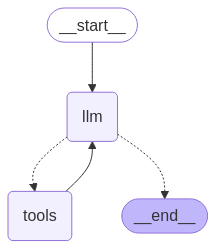

In [16]:
from IPython.display import Image, display
display(Image(agent.get_graph().draw_mermaid_png()))

#### 2.2 Usage

In [18]:
for m in llm.stream("What is Anthropic's MCP?"):
    print(m.content, end="")

I don't have information about Anthropic's specific models, capabilities, or products beyond what is publicly available. I'm Claude, an AI assistant created by Anthropic to be helpful, harmless, and honest.

In [19]:
for step in agent.stream(
    {"messages": "What is Anthropic's MCP?"},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

What is Anthropic's MCP?
================================== Ai Message ==================================
Tool Calls:
  tavily_search (toolu_bdrk_0159m2XGCqiqzDAhN6QRLic1)
 Call ID: toolu_bdrk_0159m2XGCqiqzDAhN6QRLic1
  Args:
    query: Anthropic MCP
================================= Tool Message =================================
Name: tavily_search

{"query": "Anthropic MCP", "follow_up_questions": null, "answer": null, "images": [], "results": [{"title": "Introducing the Model Context Protocol \\ Anthropic", "url": "https://www.anthropic.com/news/model-context-protocol", "content": "Today, we're open-sourcing the Model Context Protocol (MCP), a new standard for connecting AI assistants to the systems where data lives, including content repositories, business tools, and development environments. The Model Context Protocol is an open standard that enables developers to build secure, two-way connections be